In [1]:
%matplotlib inline
import xarray as xr
import datetime as dt
from datetime import timedelta
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.readers import reader_global_landmask
from opendrift.models.oceandrift import OceanDrift
import os
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('TkAgg')

In [2]:
def make_map():
    fig = plt.figure(figsize=(12,9))
    cart_proj = ccrs.PlateCarree()
    ax = plt.axes(projection=cart_proj)
    ax.coastlines('10m', linewidth=0.8,zorder=200)
    ax.set_xlim(-123.3,-122.2)
    ax.set_ylim(37.5,38.1)
    return(fig, ax)

## Model Setup ##

__1. Create the Model Object__

We will be using the OceanDrift model, which simulates ocean surface drifting, forced by surface currents, wind, and/or stokes drift.

In [3]:
o = OceanDrift(loglevel=50) # Setting the log level will give the user different amounts of info (0=Debug (all), 20=Minimum, 50=None)
# data_sets = ['Data/sfbay_2km_2020_07_20.nc','Data/sfbay_6km_2020_07_20.nc']
# reader_2km = reader_netCDF_CF_generic.Reader(data_sets[0])
# reader_6km = reader_netCDF_CF_generic.Reader(data_sets[1])
reader_2km = reader_netCDF_CF_generic.Reader("http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/2km/hourly/RTV/HFRADAR_US_West_Coast_2km_Resolution_Hourly_RTV_best.ncd")
reader_6km = reader_netCDF_CF_generic.Reader("http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/6km/hourly/RTV/HFRADAR_US_West_Coast_6km_Resolution_Hourly_RTV_best.ncd")


In [4]:
reader_landmask = reader_global_landmask.Reader(
                       extent=[-123.99,  -122.177032, 37.244221, 38.233120])  # lonmin, lonmax, latmin, latmax

ERROR:root:could not verify read permissions for group and others on landmask.
Traceback (most recent call last):
  File "/home/pdaniel/anaconda3/lib/python3.8/site-packages/opendrift_landmask_data-0.6-py3.8.egg/opendrift_landmask_data/mask.py", line 77, in __check_permissions__
    if not os.stat(self.lockf).st_mode & 0o777 == 0o777:
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/landmask/.mask.dat.lock'


__3. Add readers to model__

Data readers can be added in an hierarchical manner, from highest to lowest prioity.

In [5]:
o.add_reader([reader_landmask,reader_2km, reader_6km])


__4. Seeding the Model__

There are a several different ways to seed data, we can supply a shape file, a radius, a line etc.

From the tutorial:
```
Note that the radius is not an absolute boundary within which elements will be seeded, but one standard deviation of a normal distribution in space. Thus about 68% of elements will be seeded within this radius, with more elements near the center. By default, elements are seeded at the surface (z=0)
```

Here we could also use the OilDrift model if we wanted to simulate oils (or other density fluids).

In [6]:
# 2020-12-01 14:00:00
# 37.8016, -122.531
start_time = dt.datetime(2020,12,1,21,0)
time_step = timedelta(hours=1)
num_steps = 24

for i in range(num_steps+1):
    o.seed_elements(lon=-122.531, lat=37.8016, number=20, radius=500,
            time=start_time + i*time_step)

__5. Setting other configurations__

There are a bunch of ways to configure the model, how it reflects off of the shoreline, the advection schemes, other forcings etc.

Use `o.list_configspec()` to view the current settings

In [7]:
o.set_config('general:coastline_action', 'stranding') 
o.set_config('drift:scheme', 'runge-kutta4')
o.set_config('general:time_step_minutes', 15)
o.set_config('drift:current_uncertainty_uniform', .5) # uncertainty .2 meters per sec. this is a uniform distribution from -.2 to .2

o.set_config('drift:stokes_drift', False)

In [8]:
o.list_environment_variables()

['land_binary_mask',
 'time',
 'forecast_reference_time',
 'forecast_period',
 'surface_eastward_sea_water_velocity',
 'surface_northward_sea_water_velocity',
 'x_sea_water_velocity',
 'y_sea_water_velocity',
 'time',
 'forecast_reference_time',
 'forecast_period',
 'surface_eastward_sea_water_velocity',
 'surface_northward_sea_water_velocity',
 'x_sea_water_velocity',
 'y_sea_water_velocity']

In [9]:
base_folder= "Data/model_output/"
out_fname = "sf_bay_continuous_20_gate_" + start_time.strftime("%Y%m%dT%H%M%S")

In [10]:
os.path.join(base_folder,out_fname+".nc")

'Data/model_output/sf_bay_continuous_20_gate_20201201T210000.nc'

In [11]:
o.run(duration=timedelta(hours=48), time_step=timedelta(minutes=15), outfile=os.path.join(base_folder,out_fname+".nc")) #
# o.run(duration=timedelta(hours=48), time_step=timedelta(minutes=15)) #

In [ ]:
o.animation(legend_loc='upper center',background=["x_sea_water_velocity","y_sea_water_velocity"], fast=True,  filename='Figures/continuous-start.mp4',show_trajectories=True)

In [12]:
# o.plot(show_particles=True,background="x_sea_water_velocity")
# o.plot(compare=o_diffusion, legend=['Width diffusion', 'No diffusion'],density=True)
o.plot(density=True, filename='Figures/continuos_plot.png')
plt.show()

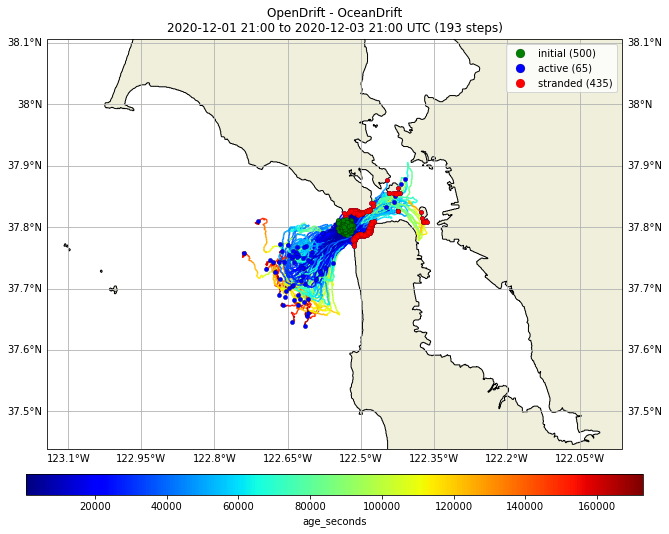

(<GeoAxesSubplot:title={'center':'OpenDrift - OceanDrift\n2020-12-01 21:00 to 2020-12-03 21:00 UTC (193 steps)'}>,
 <module 'matplotlib.pyplot' from '/home/pdaniel/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>)

In [44]:
# color='wind_drift_factor'
o.plot(linecolor='age_seconds')

# print(o)

In [16]:
o_diffusion.write_netcdf_density_map('Data/model_output/diffusion_density_large.nc',pixelsize_m=1000)

In [ ]:
o_diffusion.

In [13]:
o.reset()
o_diffusion.reset()

In [45]:
import opendrift

In [48]:
opendrift.__version__

'1.3.2'